# Human Cell Lines

In [2]:
# import mazebox as mb
import scvelo as scv
import scanpy as sc
import os.path as op
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
import dropkick as dk
# make sure to use position 1
sys.path.insert(1, "/Users/smgroves/Documents/GitHub/Groves-CellSys2021/")
import mazebox as mb
import cellrank as cr
import scanorama

In [3]:
a1 = adatas.pop(0)
adata = a1.concatenate(adatas, batch_key=batch_key, batch_categories=batch_categories)

NameError: name 'adatas' is not defined

In [21]:
verbose = False,
n_hvgs = 2000,
min_genes = 100,
min_counts = 3,
retain_genes = tfs
mito_names="^mt-|^MT-"
n_ambient=10
target_sum=None
batch_categories = batch_categories
batch_key = batch_key                                         
X_final = 'log1p_norm'

In [22]:
orig_shape = adata.shape

# store raw counts before manipulation
adata.layers["raw_counts"] = adata.X.copy()

#filter cells and genes
sc.pp.filter_cells(adata, min_genes=min_genes)
scv.pp.filter_genes(adata, min_counts=min_counts, retain_genes=retain_genes)
if verbose:
    if adata.shape[0] != orig_shape[0]:
        print(
            "Ignoring {} barcodes with less than {} genes detected".format(
                orig_shape[0] - adata.shape[0], min_genes
            )
        )
    if adata.shape[1] != orig_shape[1]:
        print(
            "Ignoring {} genes with zero total counts".format(
                orig_shape[1] - adata.shape[1]
            )
        )
adata.obs.drop(columns=["n_genes"], inplace=True)
print(adata)


Filtered out 41202 genes that are detected (3,) counts (spliced).
Ignoring 143 barcodes with less than (100,) genes detected
Ignoring 41202 genes with zero total counts
AnnData object with n_obs × n_vars = 86349 × 22475
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'cline', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'dropkick_coef-CORL279', 'dropkick_coef-DMS454', 'dropkick_coef-DMS53', 'dropkick_coef-H1048', 'dropkick_coef-H524', 'dropkick_coef-H69', 'dropkick_coef-H82', 'dropkick_coef-H841'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'raw_counts'


In [23]:

# identify mitochondrial genes
adata.var["mito"] = adata.var_names.str.contains(mito_names)
# identify putative ambient genes by lowest dropout pct (top n_ambient)
adata.var["pct_dropout_by_counts"] = np.array(
    (1 - (adata.X.astype(bool).sum(axis=0) / adata.n_obs)) * 100
).squeeze()
lowest_dropout = adata.var.pct_dropout_by_counts.nsmallest(n=n_ambient).min()
highest_dropout = adata.var.pct_dropout_by_counts.nsmallest(n=n_ambient).max()
adata.var["ambient"] = adata.var.pct_dropout_by_counts <= highest_dropout
# reorder genes by dropout rate
adata = adata[:, np.argsort(adata.var.pct_dropout_by_counts)].copy()
if verbose:
    print(
        "Top {} ambient genes have dropout rates between {} and {} percent:\n\t{}".format(
            len(adata.var_names[adata.var.ambient]),
            round(lowest_dropout, 3),
            round(highest_dropout, 3),
            adata.var_names[adata.var.ambient].tolist(),
        )
    )
# calculate standard qc .obs and .var
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mito", "ambient"], inplace=True, percent_top=None
)


# other arcsinh-transformed metrics
adata.obs["arcsinh_total_counts"] = np.arcsinh(adata.obs["total_counts"])
adata.obs["arcsinh_n_genes_by_counts"] = np.arcsinh(
    adata.obs["n_genes_by_counts"]
)

# normalize counts before transforming
sc.pp.normalize_total(adata, target_sum=target_sum, layers=None, layer_norm=None)
adata.layers["norm_counts"] = adata.X.copy()


Top 10 ambient genes have dropout rates between 0.727 and 4.87 percent:
	['MT-ND4', 'MT-ND3', 'MT-CO3', 'RPS19', 'MT-RNR2', 'MT-ND1', 'MT-ND2', 'MT-ATP6', 'MT-CYB', 'HIST1H4C']


In [26]:
# adata.layers["log1p_norm"] = adata.X.copy()  # save to .layers
sc.pp.highly_variable_genes(
    adata, n_top_genes=2000, n_bins=20, flavor="seurat"
)
adata.var.drop(columns=["dispersions", "dispersions_norm"], inplace=True)
# arcsinh-transform normalized counts (adata.layers["arcsinh_norm"])
adata.X = np.arcsinh(adata.layers["norm_counts"])
sc.pp.scale(adata)  # scale genes for feeding into model ############ If there is a discrepancy with scanpy recipe, this might be why
adata.layers[
    "arcsinh_norm"
] = adata.X.copy()  # save arcsinh scaled counts in .layers

adata.X = np.log1p(adata.layers["norm_counts"])
sc.pp.scale(adata)  # scale genes for feeding into model
adata.layers[
    "log1p_norm"
] = adata.X.copy()  # save log1p scaled counts in .layers

# remove unneeded stuff
del adata.layers["norm_counts"]

# set .X as desired for downstream processing; default raw_counts
if (X_final != "raw_counts") & verbose:
    print("Setting {} layer to .X".format(X_final))
adata.X = adata.layers[X_final].copy()

scv.tl.score_genes_cell_cycle(adata)
sc.tl.pca(adata, n_comps=50, use_highly_variable=True)

In [3]:
# sc.tl.pca(adata)
# sc.pl.pca(adata, color = 'cline')

In [4]:
# sc.pp.neighbors(adata, random_state=0)
# sc.tl.umap(adata, random_state=0)
# sc.pl.umap(adata, color = 'cline')

In [5]:
# mb.pp.scanorama_recipe(adata, groups = 'cline', correct = True, basis = 'umap')

In [5]:
# mb.pp.scanpy_recipe(adata_full, retain_genes=tfs)


Filtered out 45412 genes that are detected in less than 3 cells (spliced).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


AnnData object with n_obs × n_vars = 16671 × 18265
    obs: 'cline', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr'
    uns: 'cline_colors'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [6]:
# adata_check = adata_full.copy()

In [9]:
# adata_check.X.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# RNA Velocity on all cell lines

In [4]:
adata = cr.read('../../out/cell-lines/adata_03.h5ad')

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.read` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


In [5]:
adata

AnnData object with n_obs × n_vars = 13945 × 20446
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'cline', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_scores_ind', 'predicted_doublets_ind', 'M', 'E', 'clusters_gradients', 'cell_cycle_diff', 'score', 'SCLC-Y_Score', 'SCLC-P_Score', 'SCLC-N_Score', 'SCLC-A2_Score', 'SCLC-A_Score', 'Phenotype', 'SCLC-A_Score_pos', 'SCLC-A2_Score_pos', 'SCLC-N_Score_pos', 'SCLC-P_Score_pos', 'SCLC-Y_Score_pos', 'arc_pheno', 'arc_aa_type'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'dropkick_coef-CORL279', 'dropkick_coef-DMS454', 'dropkick_coef-DMS53', 'dropkick_

## Calculating Velocity

In [9]:
scv.pp.neighbors(adata) # subsetting corrupted neighborhood graph-- redo here
scv.pp.moments(adata)
# scv.tl.velocity(adata, mode = 'deterministic', groupby='cline')
# scv.tl.velocity_graph(adata)
scv.tl.recover_dynamics(adata, n_jobs=8) #uses velocity genes from deterministic model as default
scv.tl.velocity(adata, mode="dynamical")
scv.tl.velocity_graph(adata)

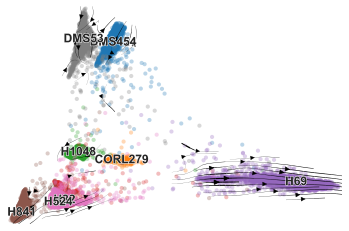

In [12]:
scv.pl.velocity_embedding_stream(
    adata, basis="pca_imputed", legend_fontsize=12, title="", smooth=0.8, min_mass=4, color = 'cline'
)

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


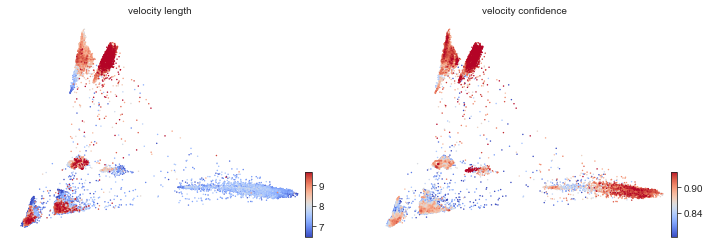

In [13]:
scv.tl.velocity_confidence(adata)

keys = 'velocity_length', 'velocity_confidence'  
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95], basis = 'pca_imputed')



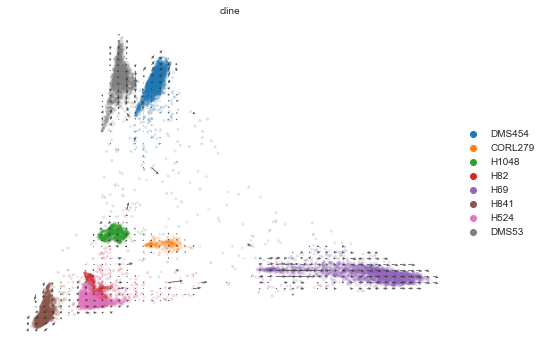

In [14]:
scv.pl.velocity_embedding_grid(adata, vkey='velocity',basis = 'pca_imputed', figsize = (8,6), legend_loc = 'on right',color = 'cline')


Let's save the data at this point.

In [15]:
adata.write_h5ad('../../out/cell-lines/adata_03.h5ad')



In [128]:
adata = sc.read_h5ad('../../out/cell-lines/adata_03.h5ad')



## Kinetic Rate Parameters

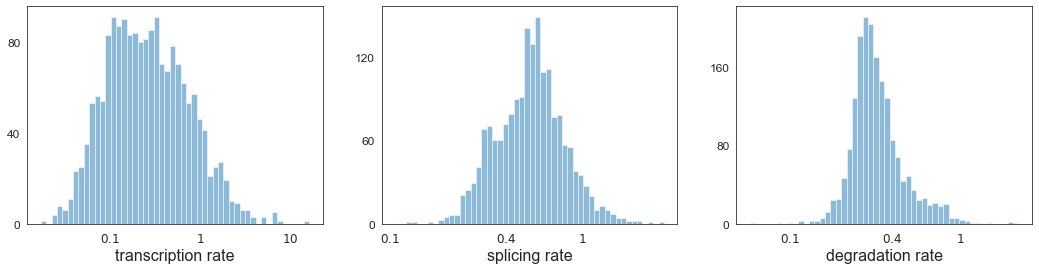

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/scvelo/core/_anndata.py:311: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.var_names = df.index


fit_r2  fit_alpha   fit_beta  fit_gamma     fit_t_  fit_scaling  \
Gene                                                                          
RPL11     0.091543   5.972059  40.123885   0.253127   5.445346     0.007519   
ACTB      0.177415   6.204240  25.467158   0.322686  12.948350     0.020051   
HSP90AA1  0.168188   3.966881  23.290030   0.288245  11.384696     0.019220   
RPL10-1   0.143077   4.644354  30.430824   0.282687   8.036643     0.013243   
RPL27     0.154780   3.913085  25.485818   0.376735   4.766925     0.012168   

          fit_std_u  fit_std_s  fit_likelihood  fit_u0  fit_s0  \
Gene                                                             
RPL11      0.048072   3.692347        0.192325     0.0     0.0   
ACTB       0.066598   4.475625        0.151449     0.0     0.0   
HSP90AA1   0.057937   3.569511        0.213459     0.0     0.0   
RPL10-1    0.049871   4.151801        0.248473     0.0     0.0   
RPL27      0.038017   1.585582        0.258123     0.0     0.0   

          fit_pval_steady  fit_steady_u  fit_steady_s  fit_variance  \
Gene                                                                  
RPL11            0.496662      0.158810     13.214035      1.459811   
ACTB             0.499374      0.296729     16.005891      1.807576   
HSP90AA1         0.493478      0.174631     14.679875      1.090066   
RPL10-1          0.494416      0.151762     12.593600      0.650308   
RPL27            0.492383      0.132568      4.847104      0.757727   

          fit_alignment_scaling  
Gene                             
RPL11                  1.914279  
ACTB                   2.374940  
HSP90AA1               2.267452  
RPL10-1                2.344932  
RPL27                  1.558562

In [16]:
df = adata.var
df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]

kwargs = dict(xscale='log', fontsize=16)
with scv.GridSpec(ncols=3) as pl:
    pl.hist(df['fit_alpha'], xlabel='transcription rate', **kwargs)
    pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
    pl.hist(df['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)

scv.get_df(adata, 'fit*', dropna=True).head()

# RNA Velocity By Cell Line

I think our best bet is to just split up the adata object by cell line and run each individually. It would be nice to visualize all together, but some of the functions do not have a `groupby` parameter, and I'm worried calculating something like latent time across samples would infer latent time incorrectly.

In [46]:
import warnings

warnings.simplefilter("ignore", category=DeprecationWarning)

def rna_velocity_recipe(adata, copy = False, basis = 'pca_imputed', resolution = .5, save = False):
    a = adata.copy() if copy else adata

    scv.pp.neighbors(a) # subsetting results in corrupted neighborhood graph-- redo here
    sc.tl.leiden(a, random_state = 0, resolution = resolution)         
            
    scv.pp.moments(a)
    # scv.tl.velocity(adata, mode = 'deterministic', groupby='cline')
    # scv.tl.velocity_graph(adata)
    
    ## Recover dynamics
    #see case 2 in https://github.com/theislab/scvelo/issues/497
    if 'velocity_genes' in a.var.columns:
        a.var.drop('velocity_genes',axis=1,inplace=True)

    scv.tl.recover_dynamics(a, n_jobs=8) #uses velocity genes from steady state model as default, but does not add them as attribute!
    scv.tl.velocity(a, mode="dynamical") #now this adds velocity_genes attribute to a
    scv.tl.velocity_graph(a)
    
    ## Plot embedding stream
    scv.pl.velocity_embedding_stream(a, basis=basis, legend_fontsize=12, title="", smooth=0.8, min_mass=4, color = 'leiden', save="velocity_embedding_stream_"+save)
    
    ## Velocity confidence
    scv.tl.velocity_confidence(a)
    keys = 'velocity_length', 'velocity_confidence'  
    scv.pl.scatter(a, c=keys, cmap='coolwarm', perc=[5, 95], basis = basis, save="velocity_confidence_"+save)
    scv.pl.velocity_embedding_grid(a, vkey='velocity',basis = basis, figsize = (8,6), legend_loc = 'on right',color = 'leiden', save="velocity_embedding_grid_"+save)
    
    ## Kinetic rate parameters
    df = a.var
    df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]

    kwargs = dict(xscale='log', fontsize=16)
    with scv.GridSpec(ncols=3) as pl:
        pl.hist(df['fit_alpha'], xlabel='transcription rate', **kwargs)
        pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
        pl.hist(df['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)
    
    #Latent time
    scv.tl.latent_time(a)
    scv.pl.scatter(a, color='latent_time', color_map='gnuplot', size=80, basis = basis, save= "latent_time"+save)
    
    #Fit Genes
    top_genes = a.var['fit_likelihood'].sort_values(ascending=False).index
    scv.pl.scatter(a, basis=top_genes[:15], ncols=5, frameon=False, color = 'leiden', save = "top_gene_fits_leiden_"+save)
    scv.pl.scatter(a, basis=top_genes[:15], ncols=5, frameon=False, color = 'latent_time', save = "top_gene_fits_LT"+save)

    return a if copy else None


  0%|          | 0/699 [00:00<?, ?gene/s]

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/scvelo/tools/dynamical_model.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/scvelo/tools/dynamical_model.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


  0%|          | 0/2005 [00:00<?, ?cells/s]

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


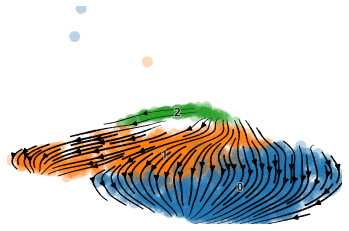

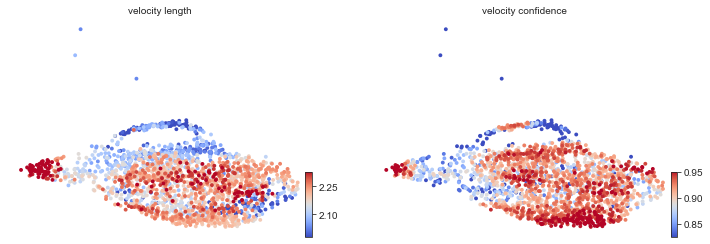

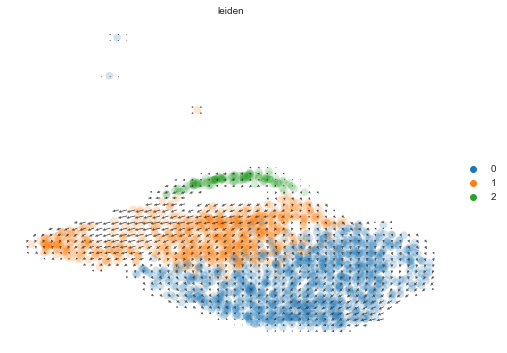

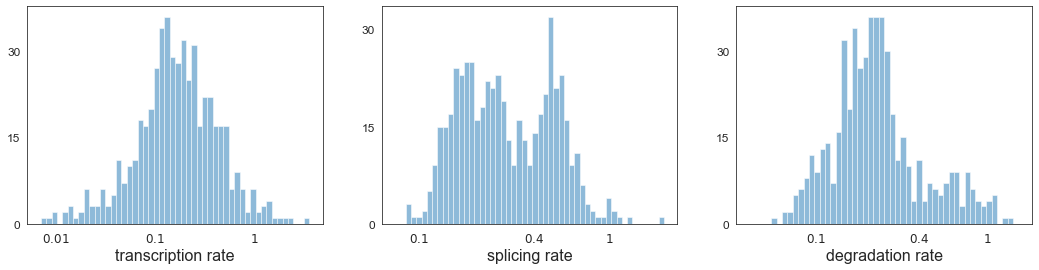

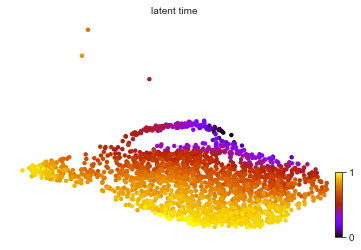

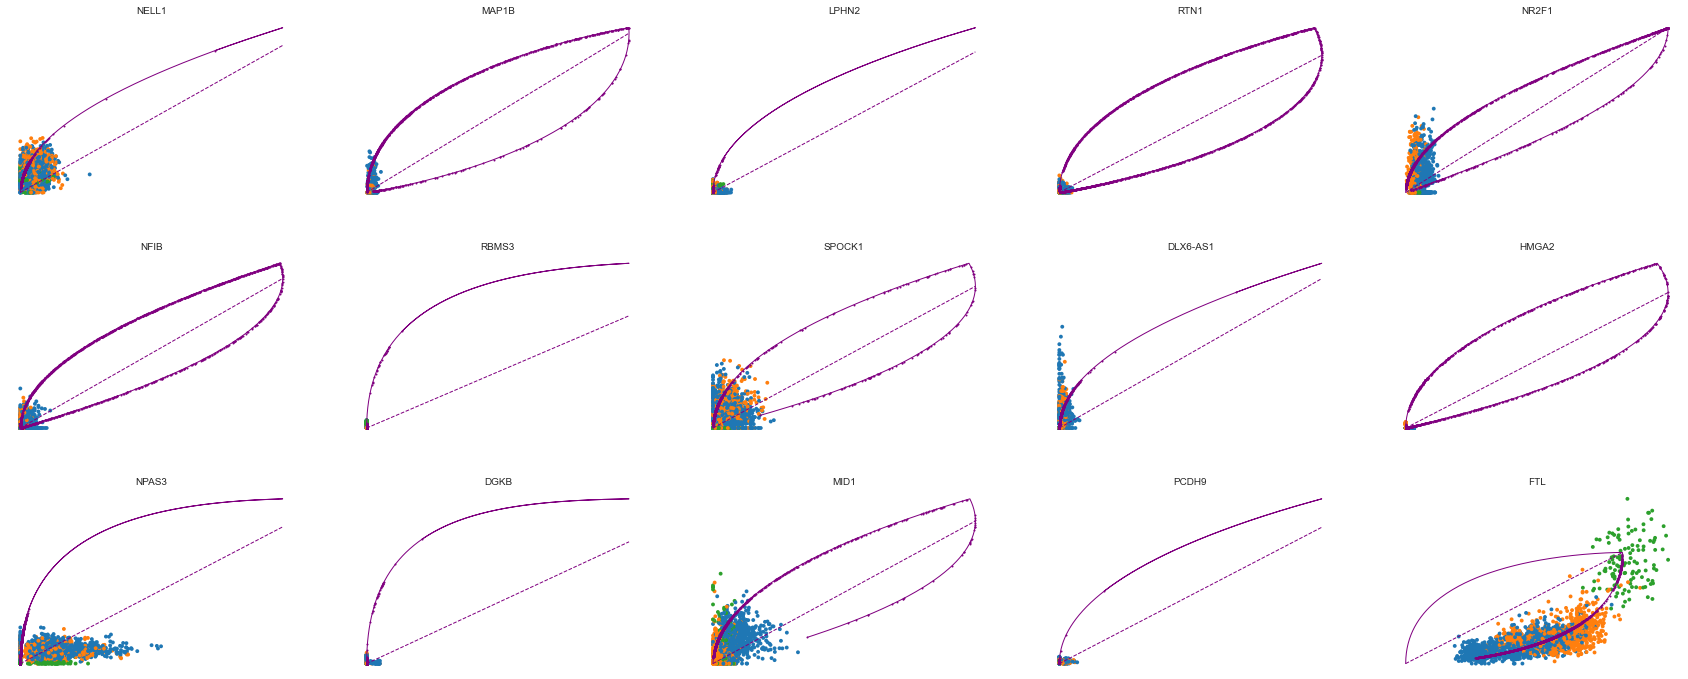

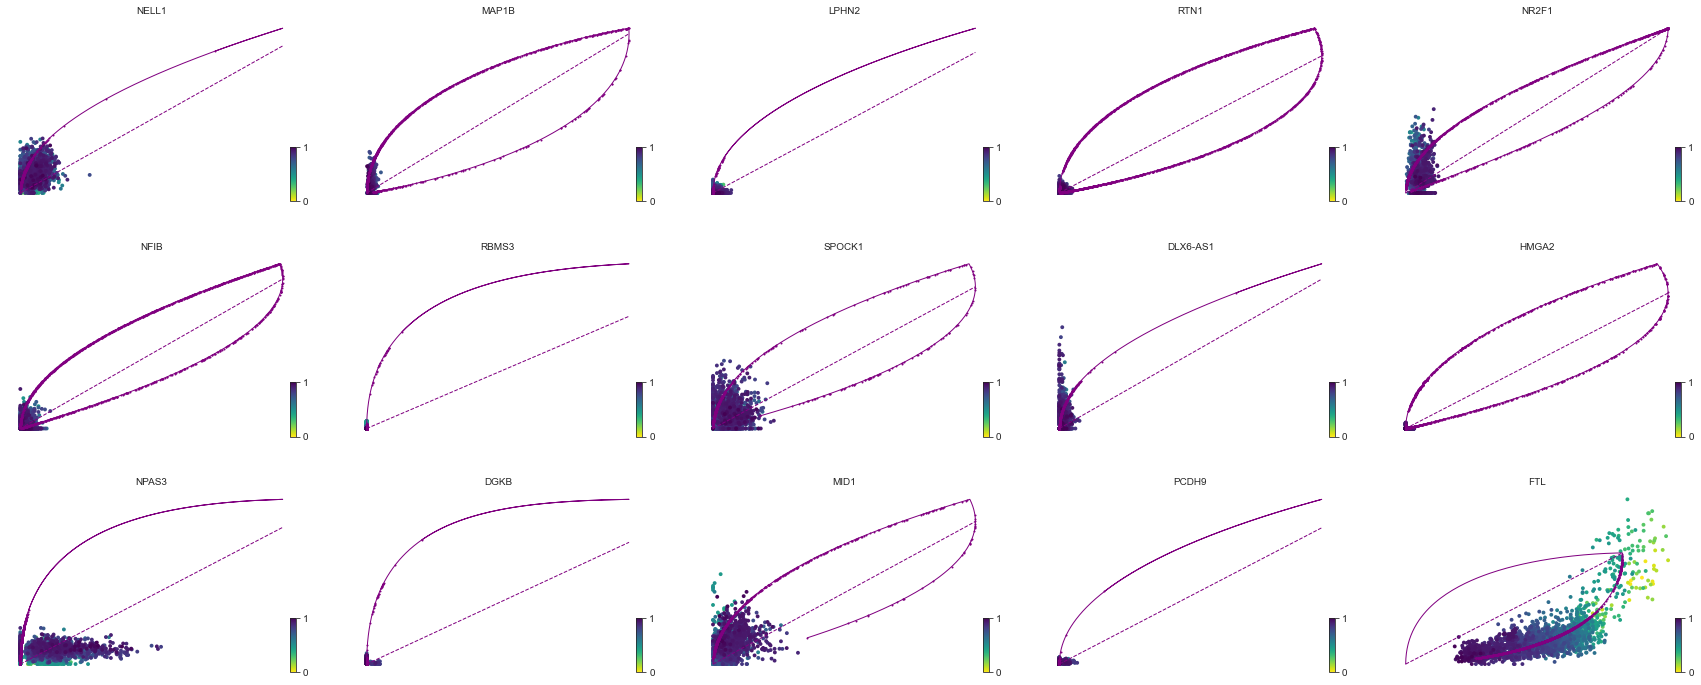

  0%|          | 0/1559 [00:00<?, ?gene/s]

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/scvelo/tools/dynamical_model.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/scvelo/tools/dynamical_model.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


  0%|          | 0/228 [00:00<?, ?cells/s]

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


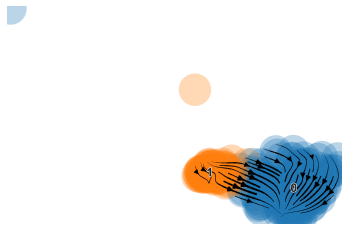

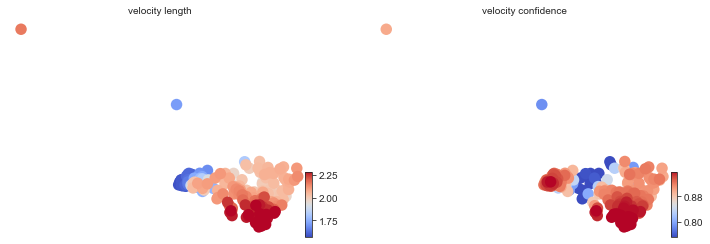

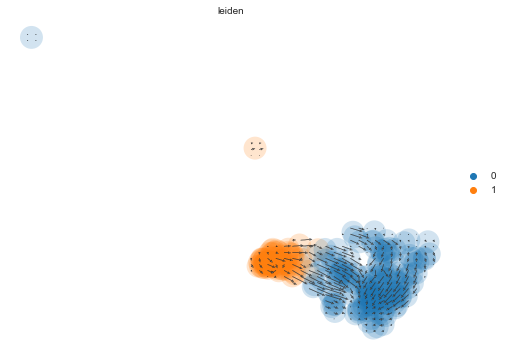

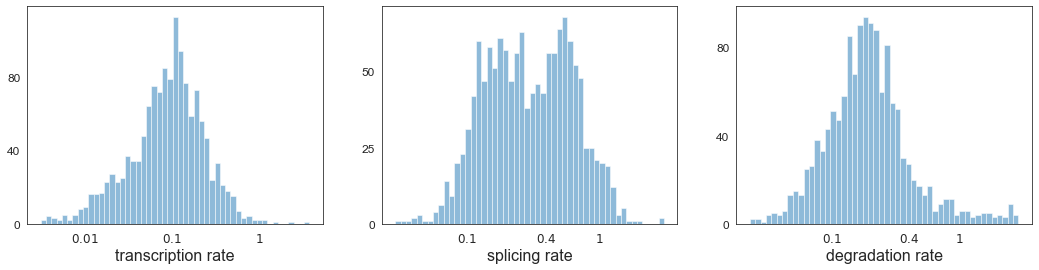

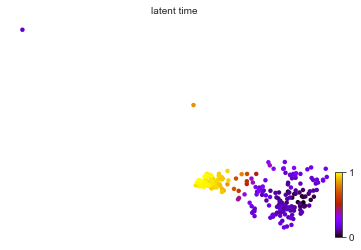

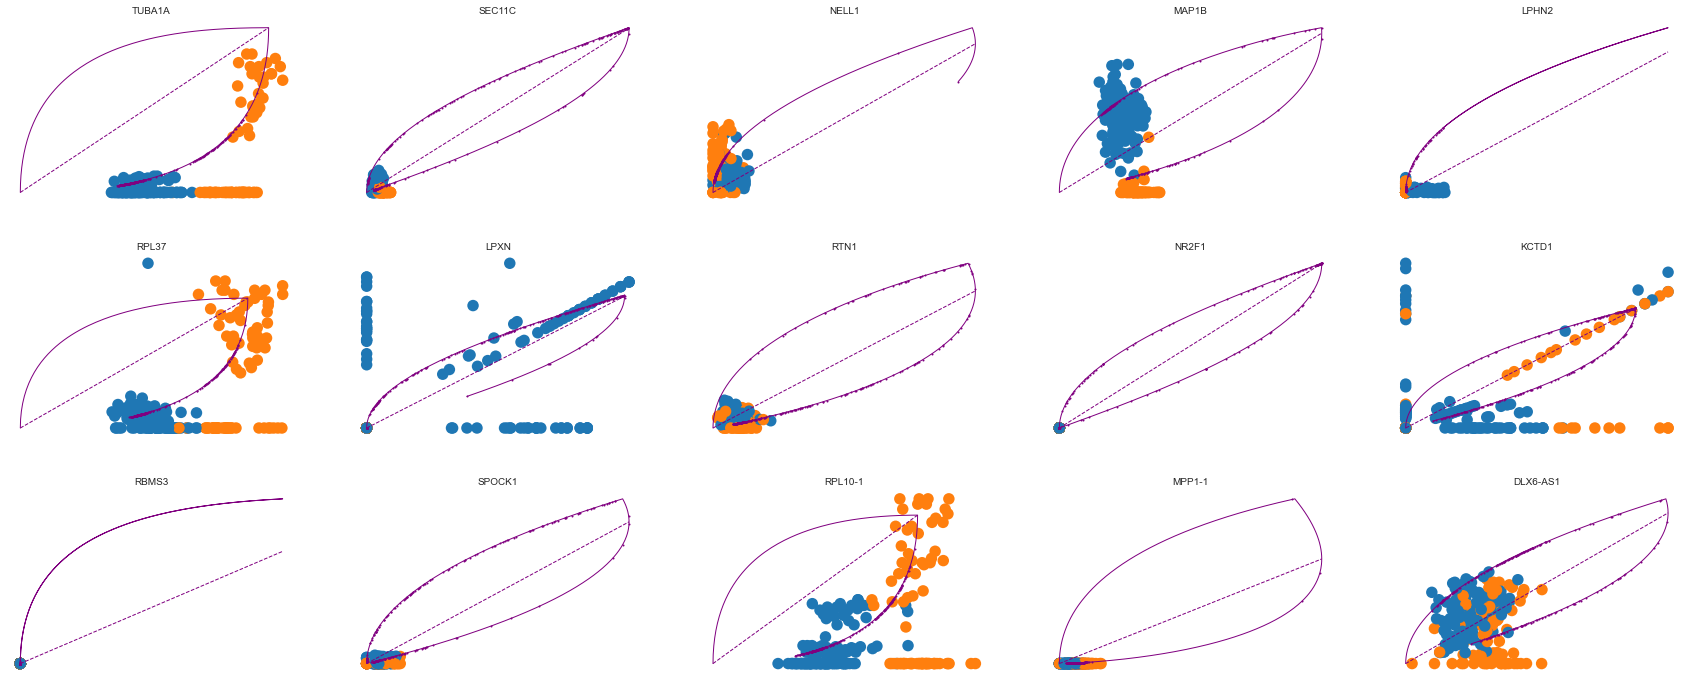

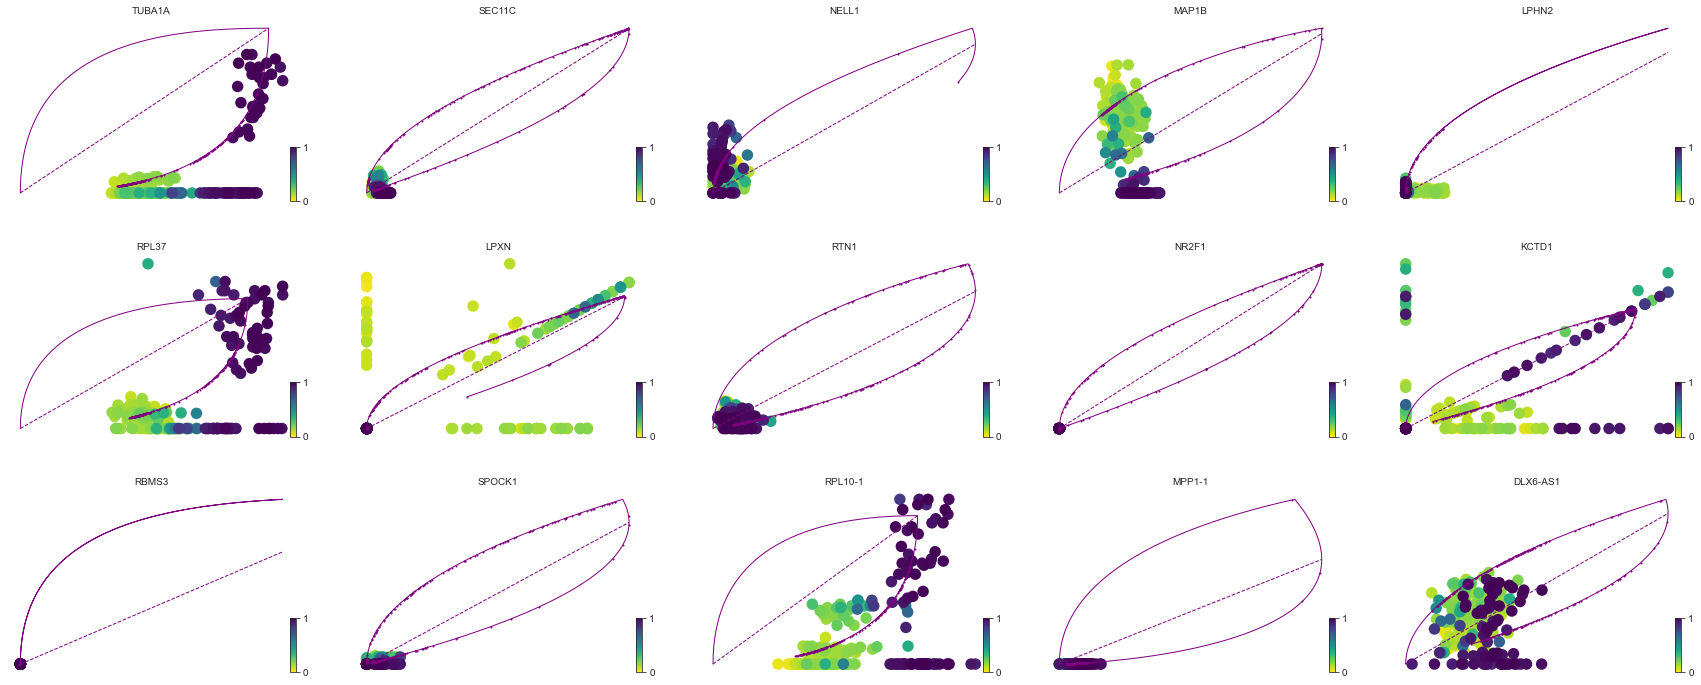

  0%|          | 0/1092 [00:00<?, ?gene/s]

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/scvelo/tools/dynamical_model.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/scvelo/tools/dynamical_model.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


  0%|          | 0/949 [00:00<?, ?cells/s]

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


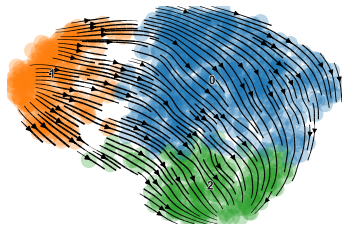

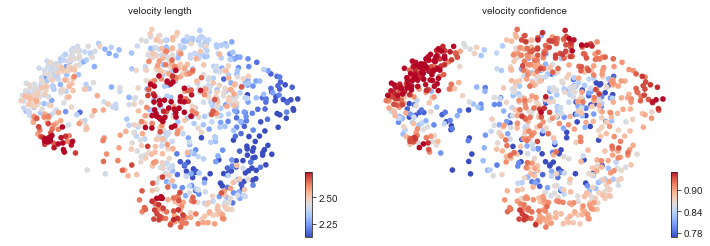

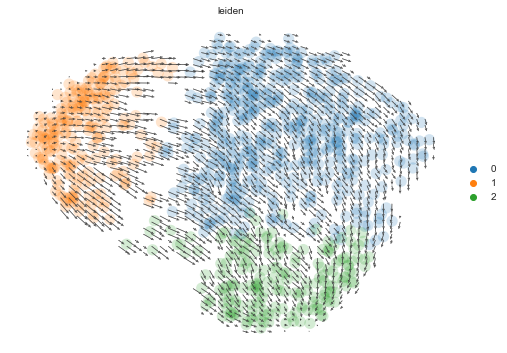

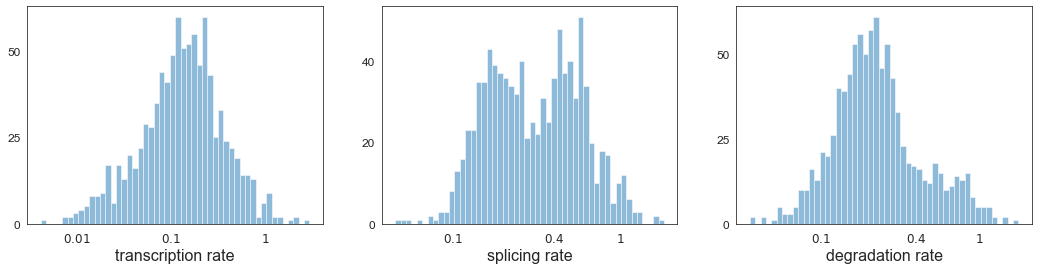

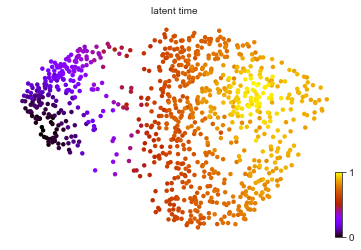

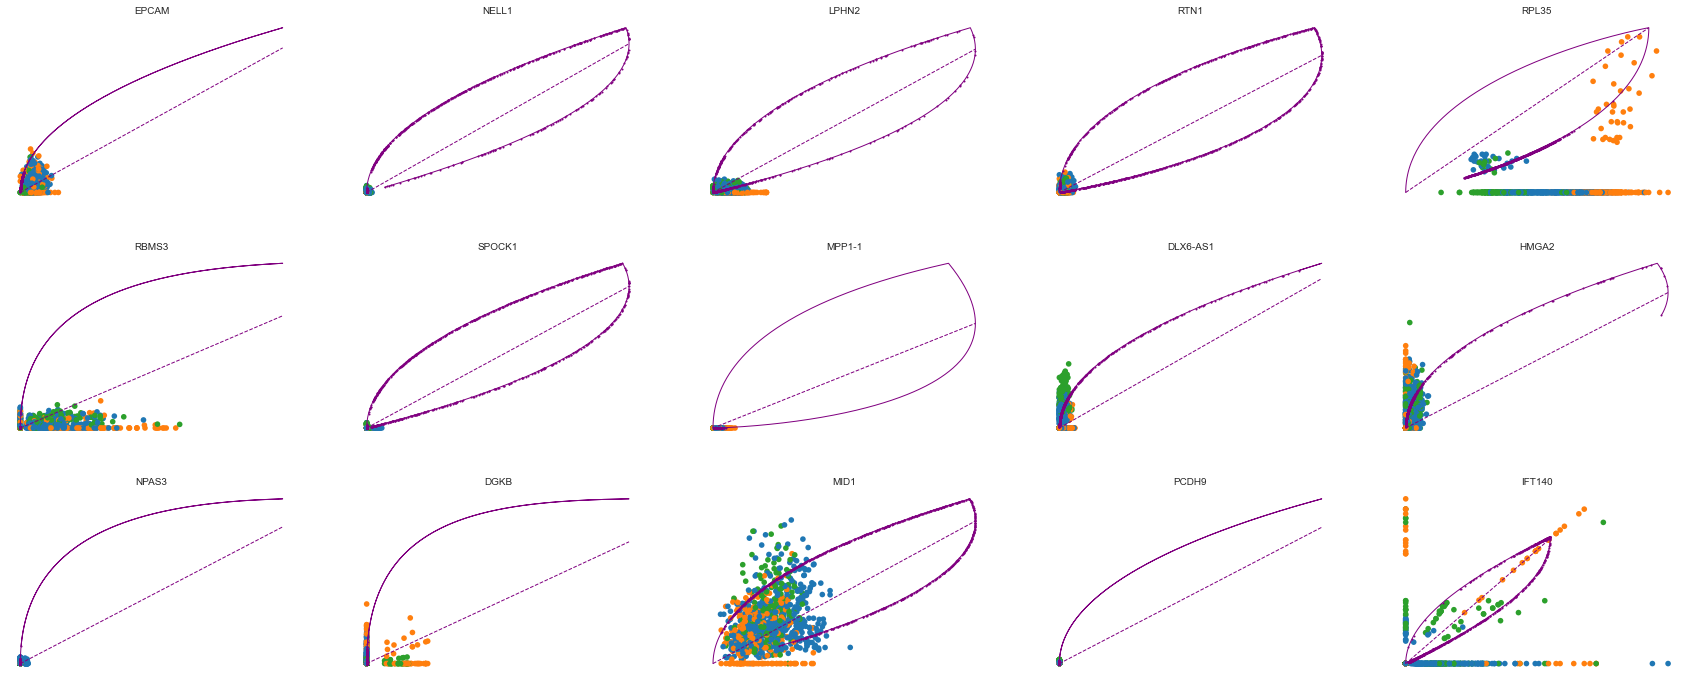

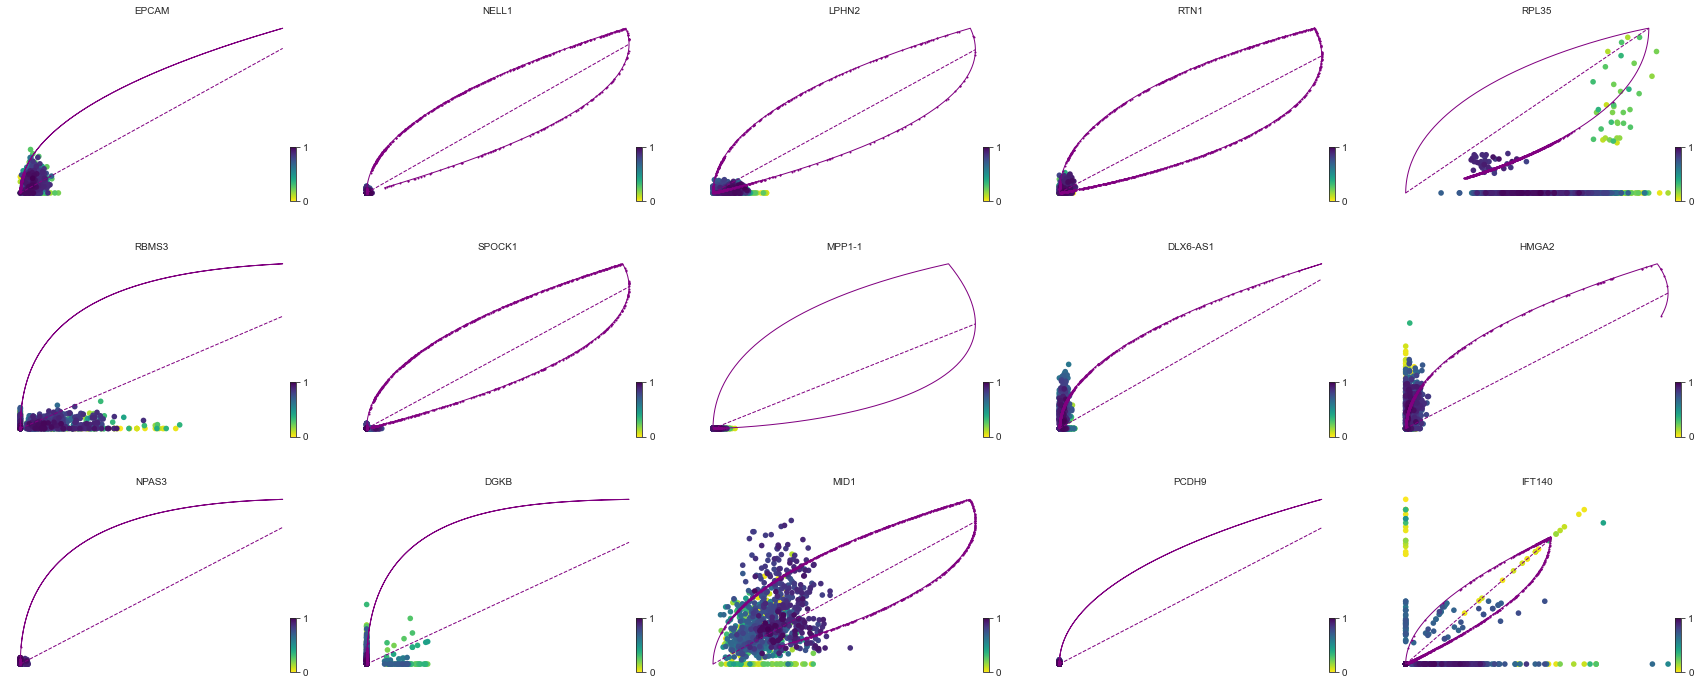

  0%|          | 0/886 [00:00<?, ?gene/s]

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/scvelo/tools/dynamical_model.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/scvelo/tools/dynamical_model.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


  0%|          | 0/1709 [00:00<?, ?cells/s]

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


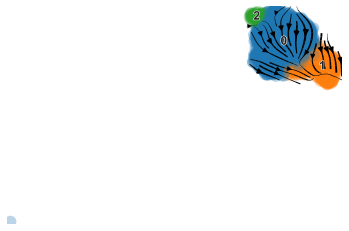

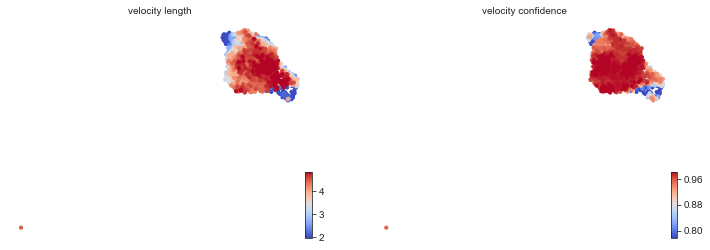

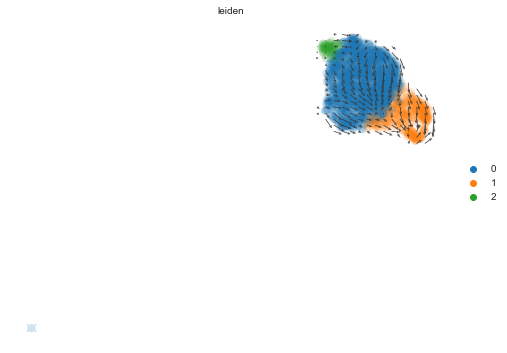

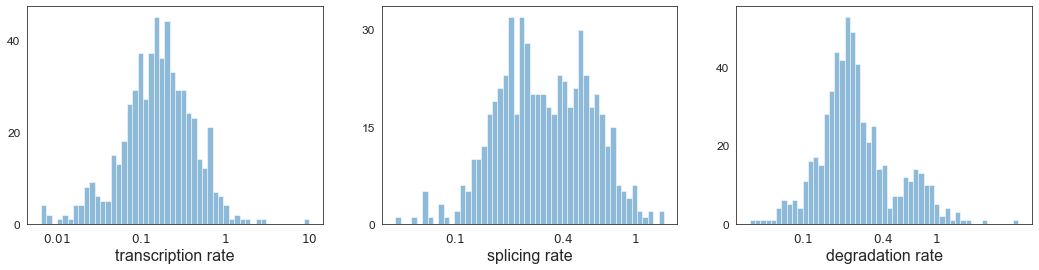

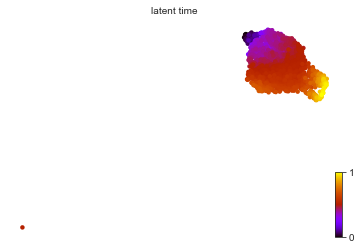

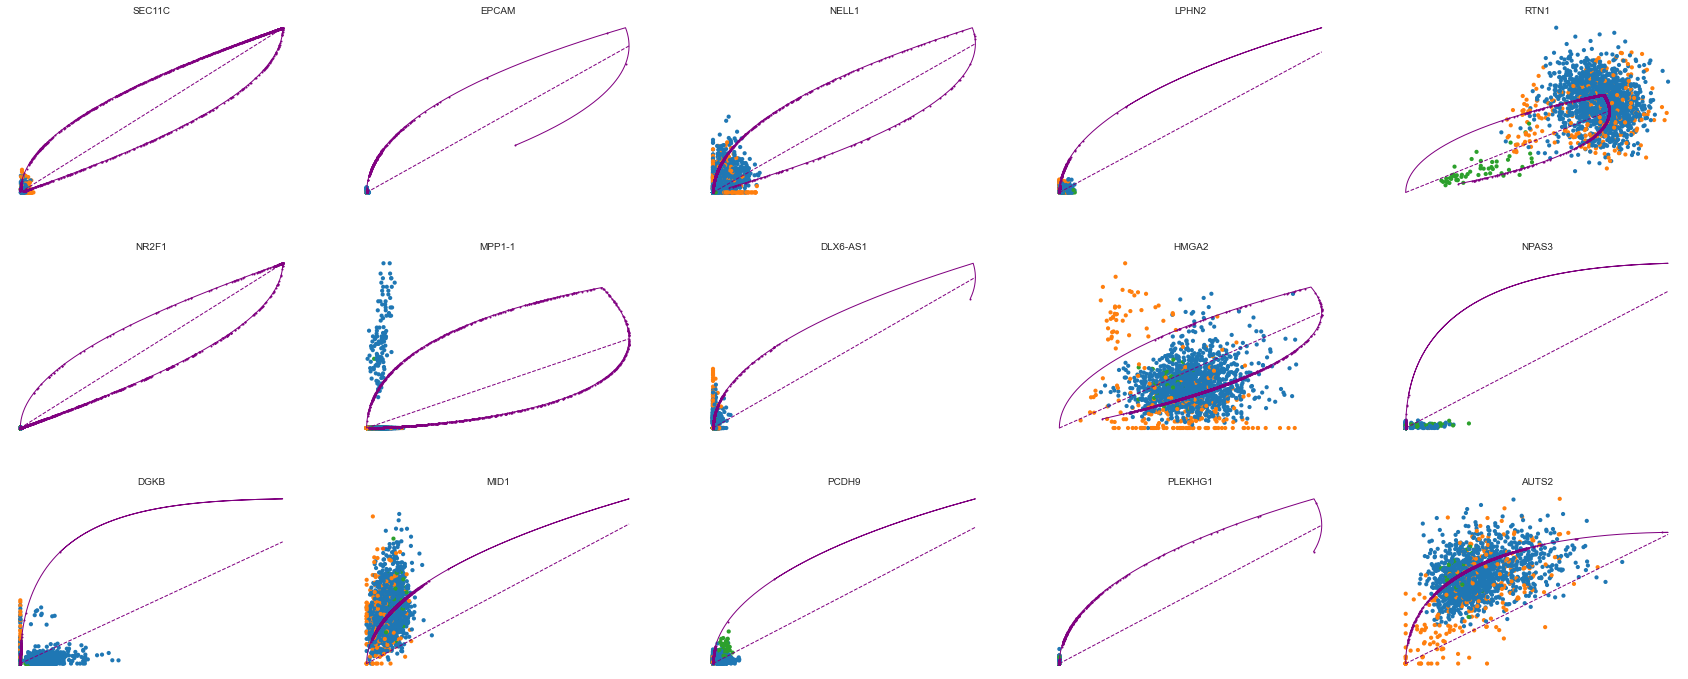

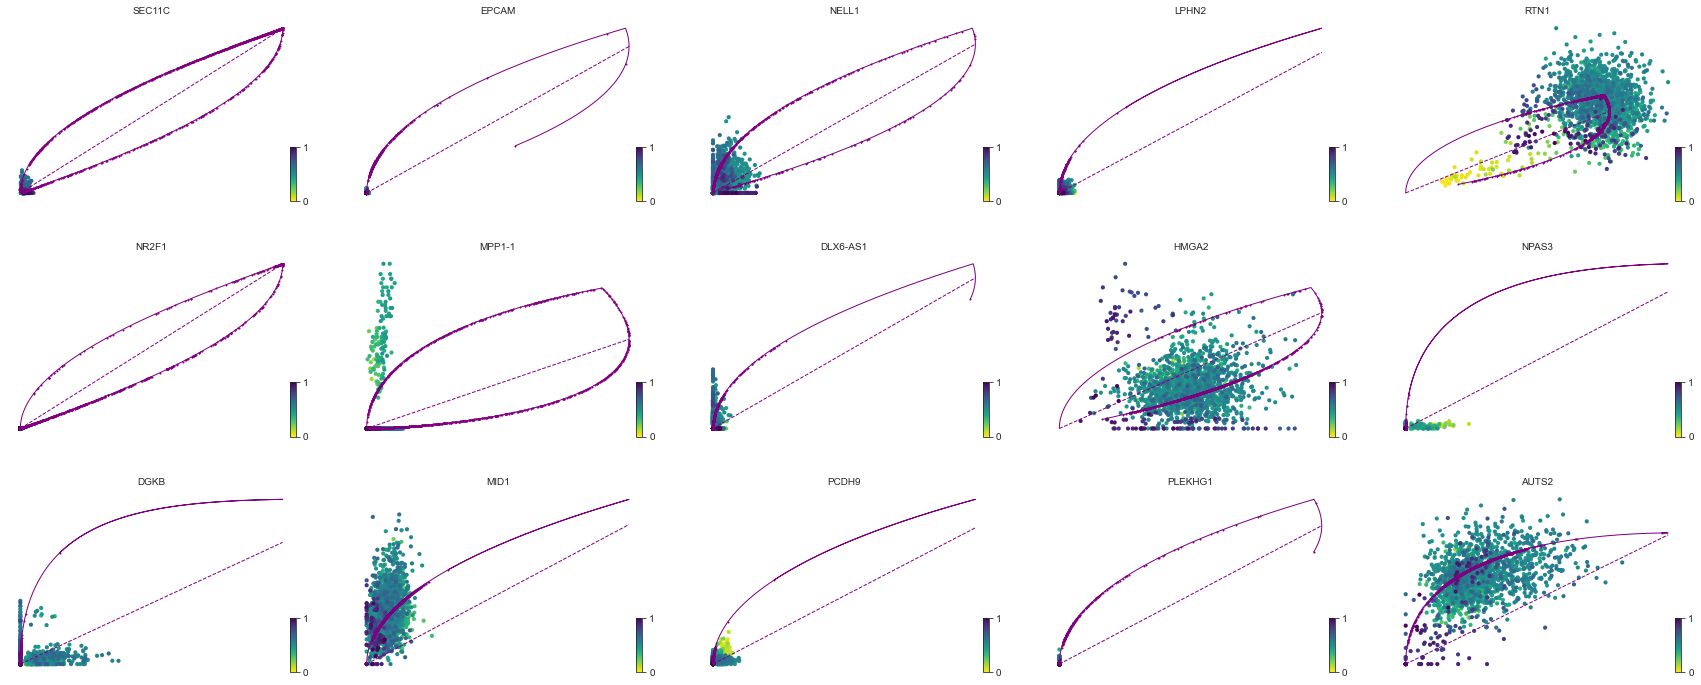

  0%|          | 0/796 [00:00<?, ?gene/s]

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/scvelo/tools/dynamical_model.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/scvelo/tools/dynamical_model.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


  0%|          | 0/2797 [00:00<?, ?cells/s]

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


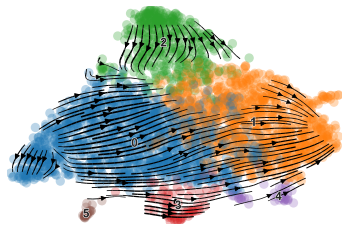

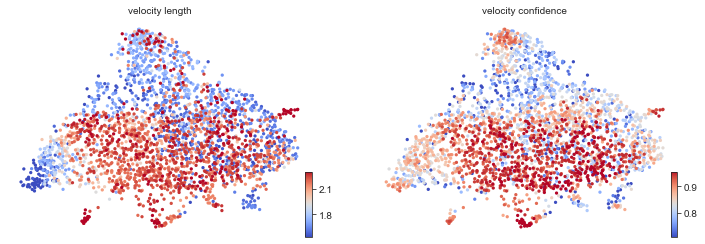

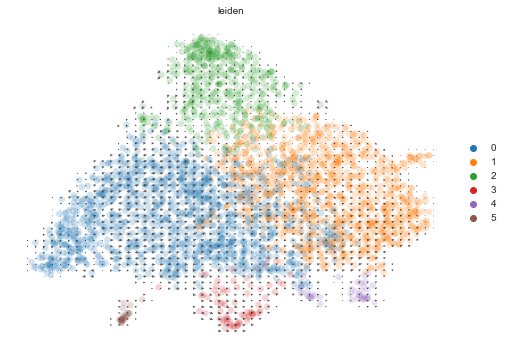

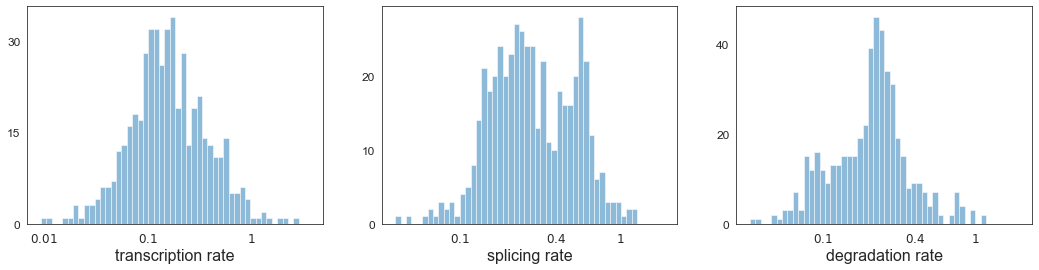

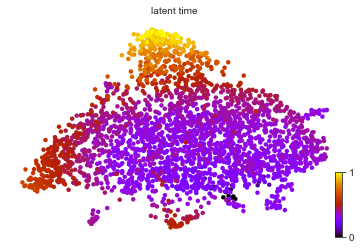

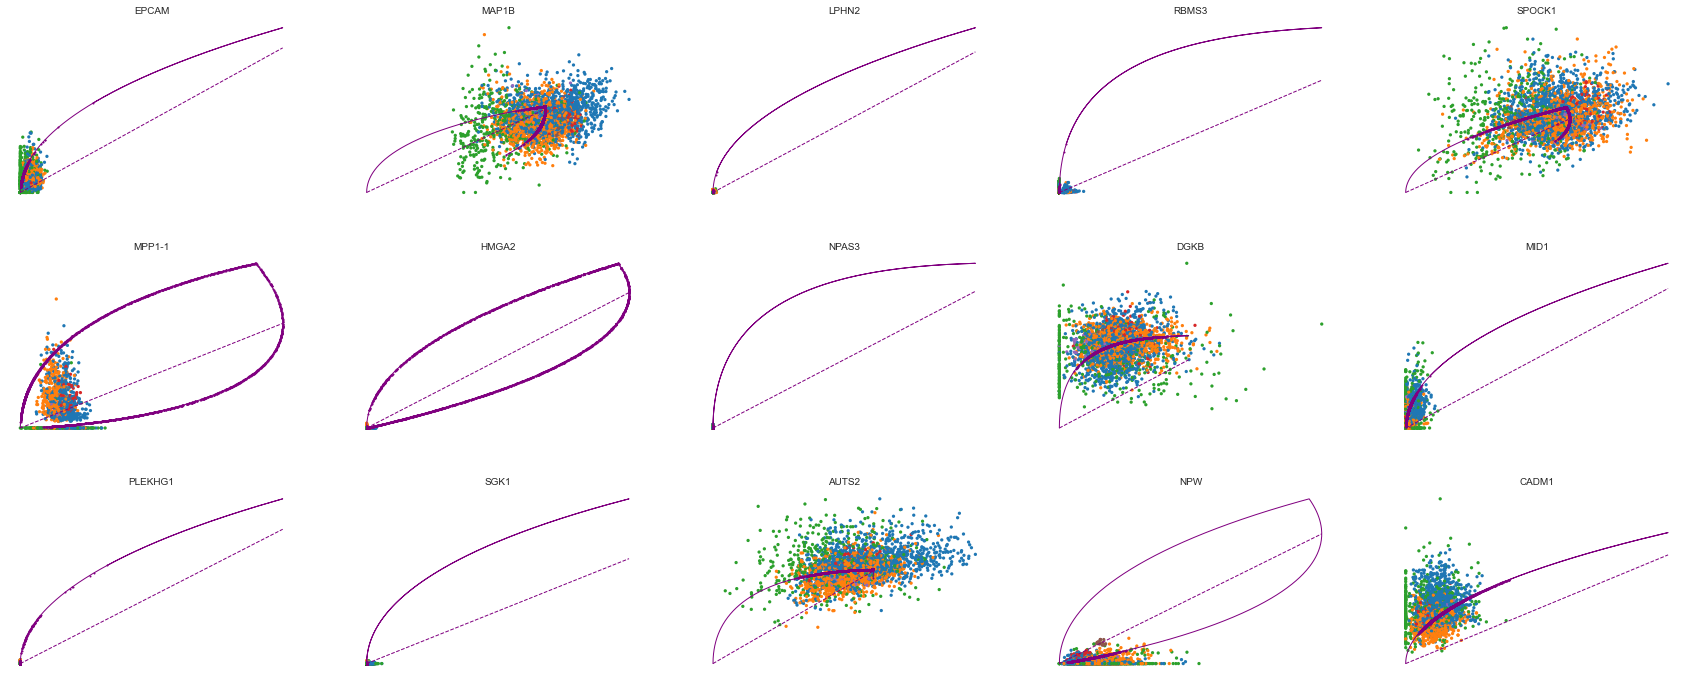

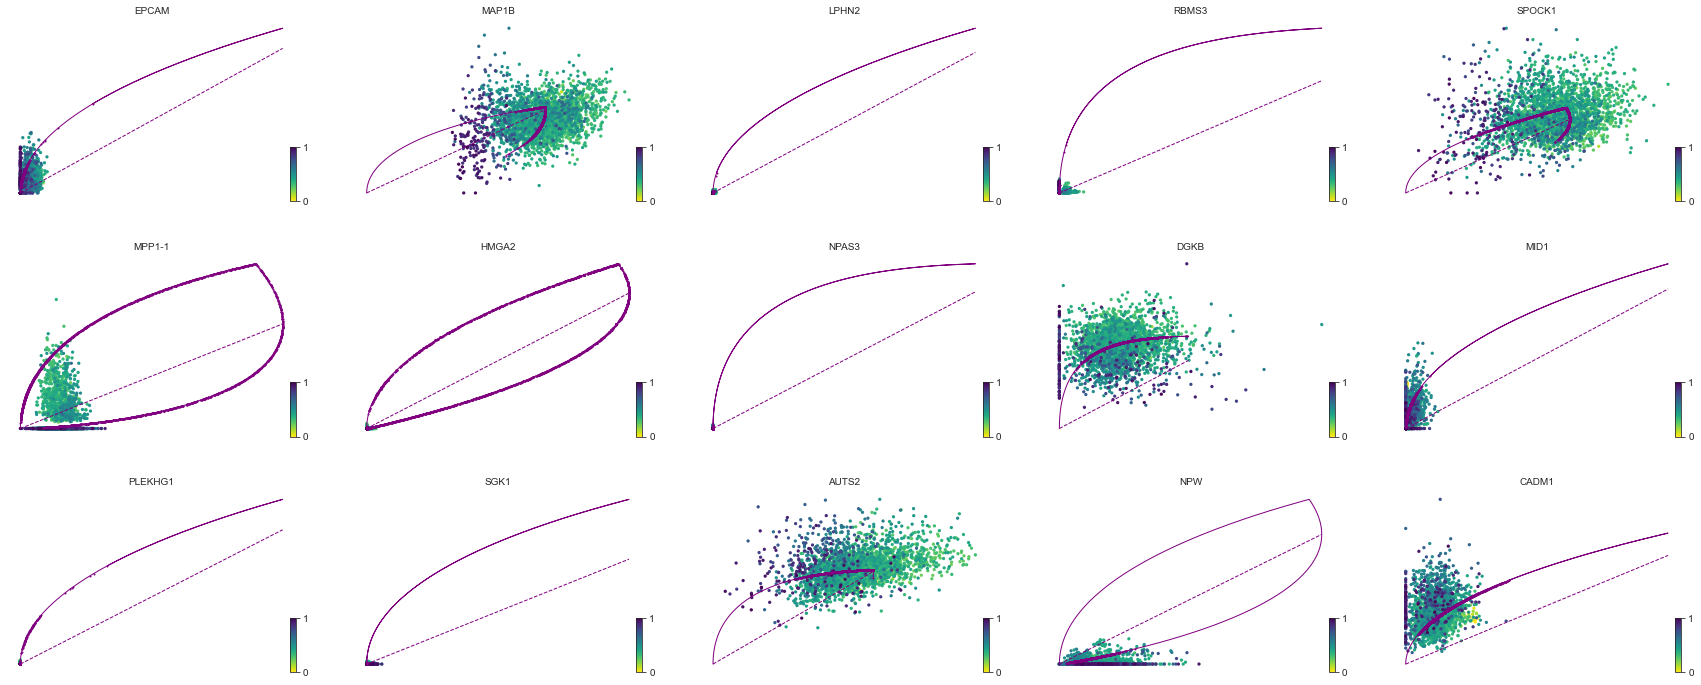

  0%|          | 0/571 [00:00<?, ?gene/s]

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/scvelo/tools/dynamical_model.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/scvelo/tools/dynamical_model.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


  0%|          | 0/2063 [00:00<?, ?cells/s]

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


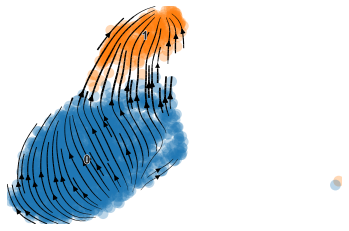

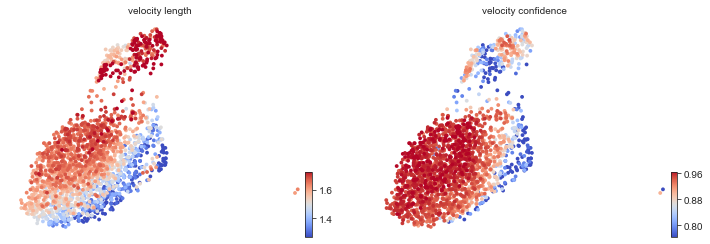

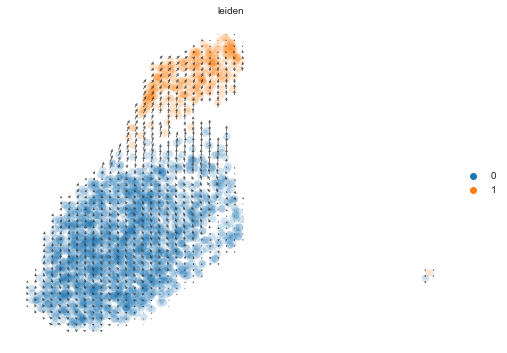

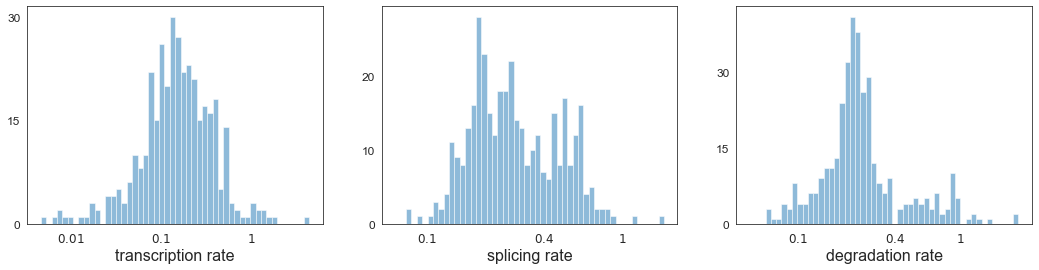

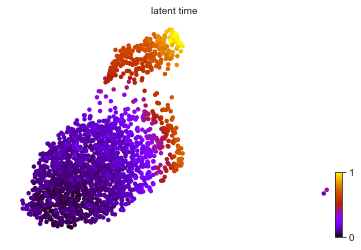

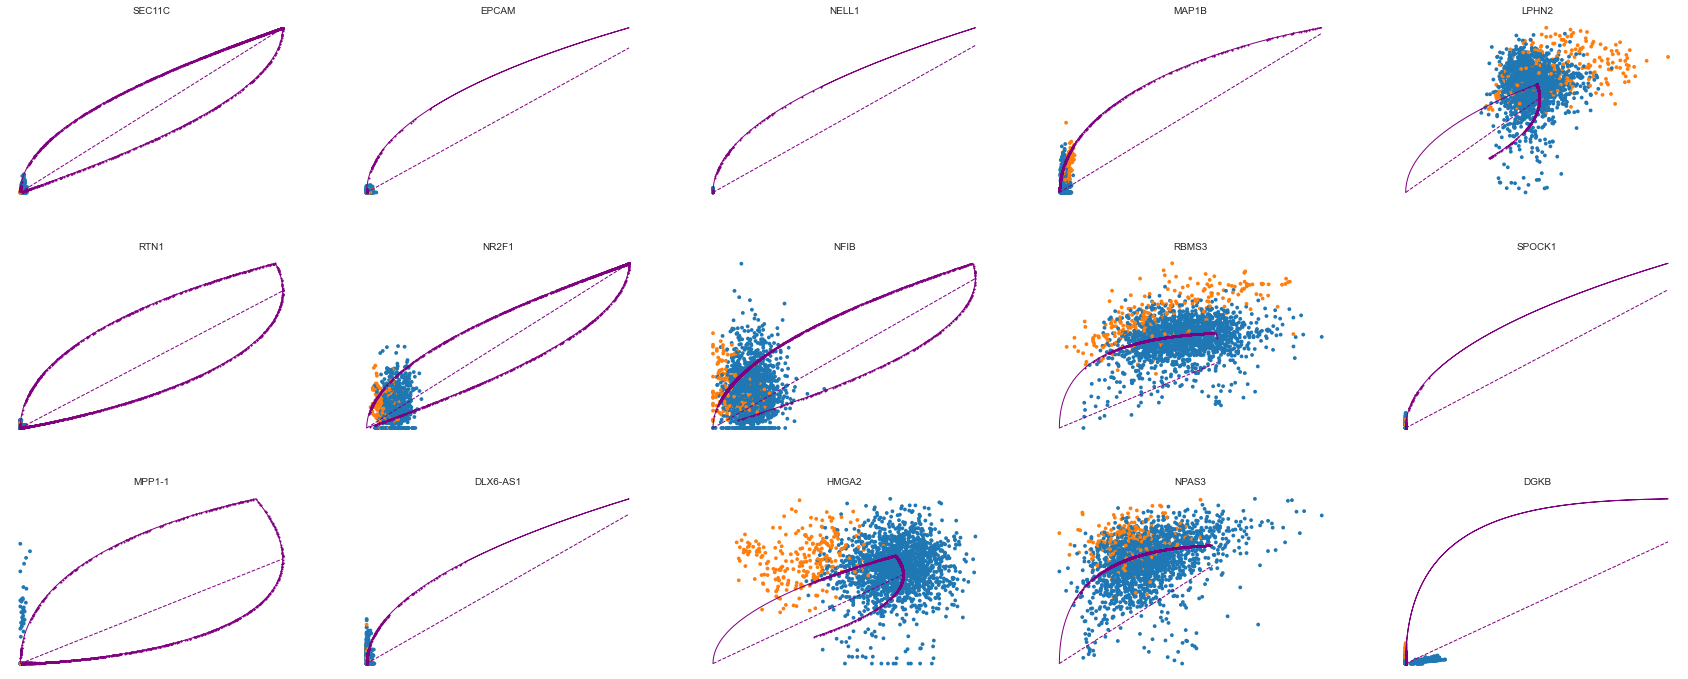

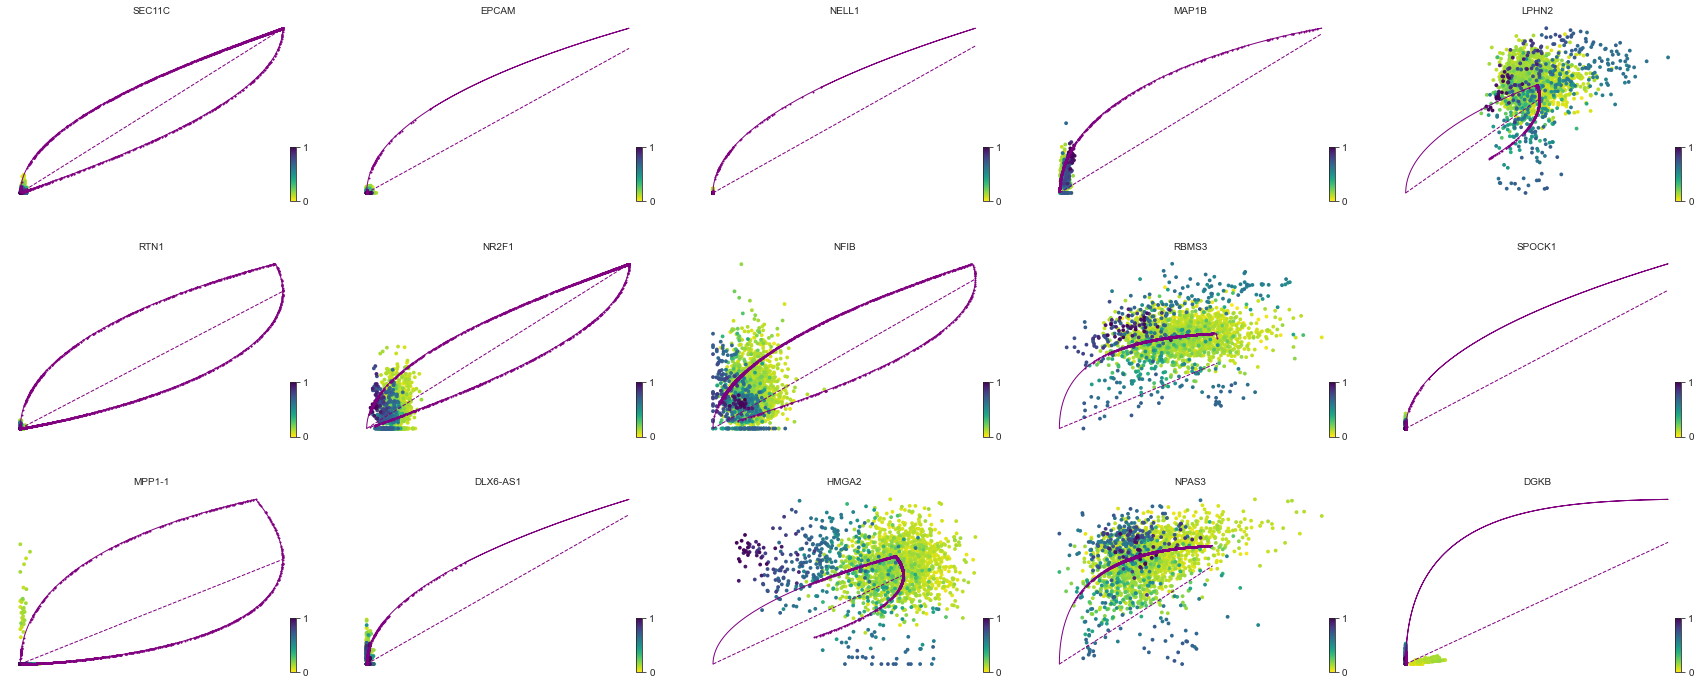

  0%|          | 0/650 [00:00<?, ?gene/s]

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/scvelo/tools/dynamical_model.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/scvelo/tools/dynamical_model.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


  0%|          | 0/2345 [00:00<?, ?cells/s]

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


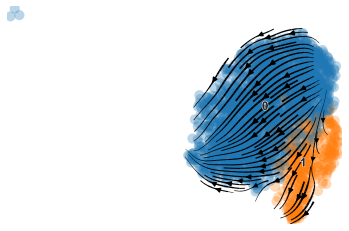

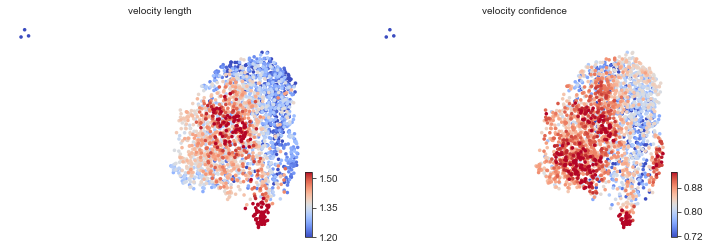

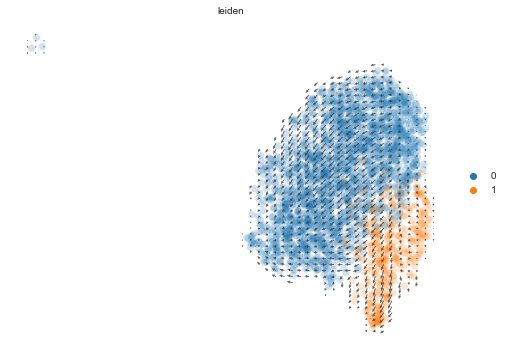

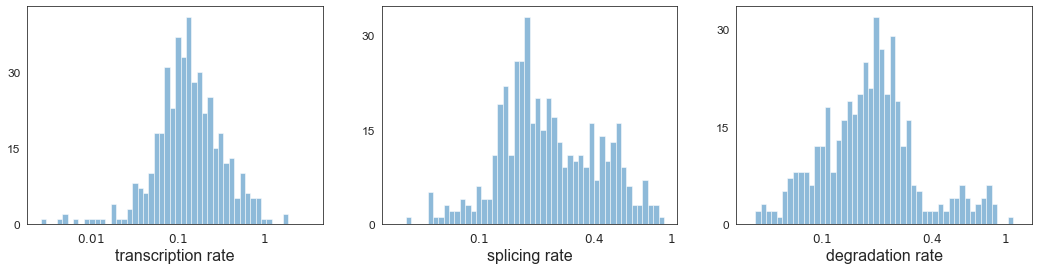

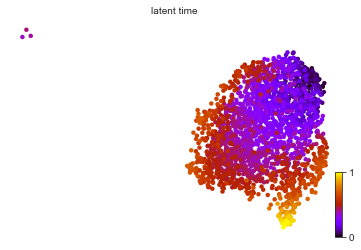

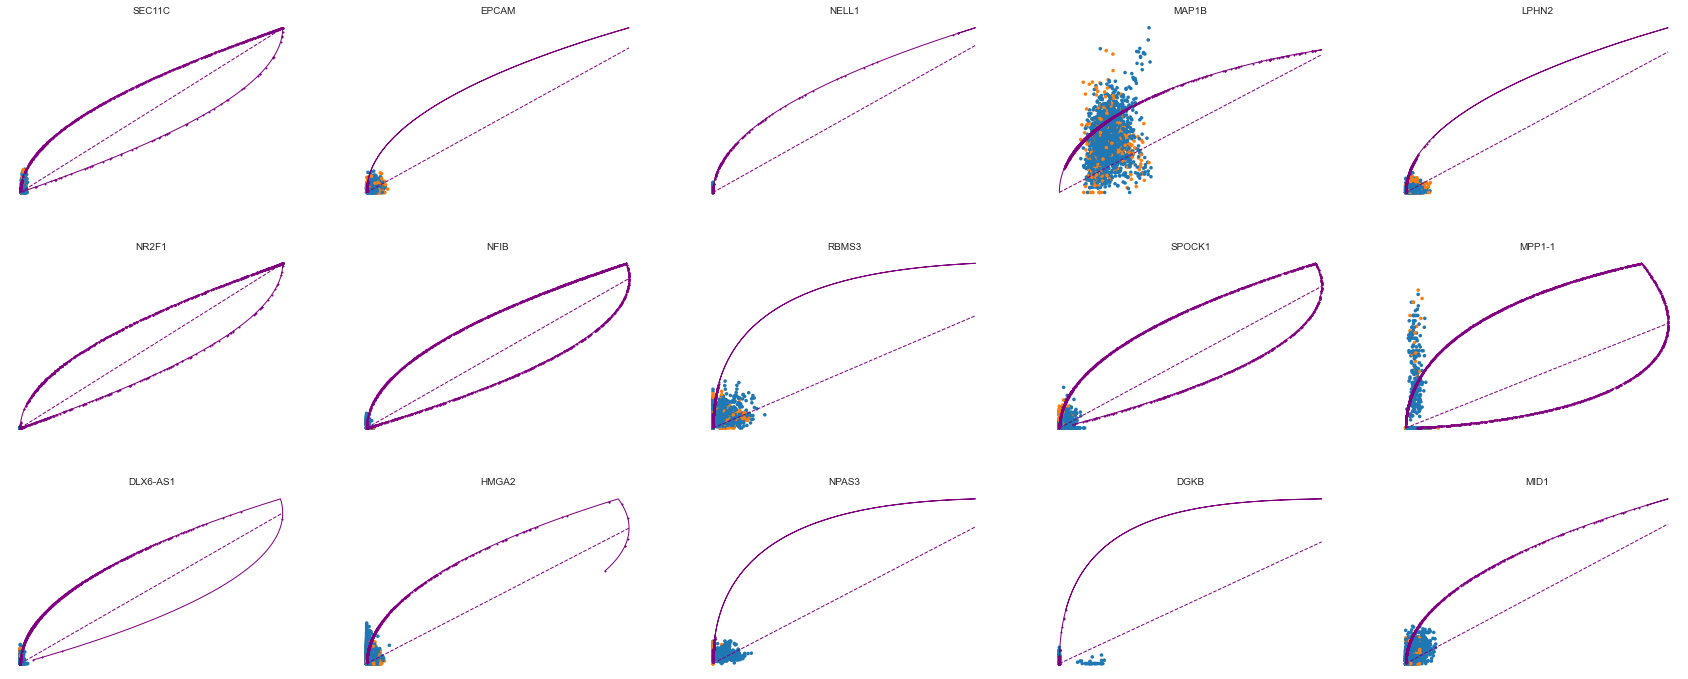

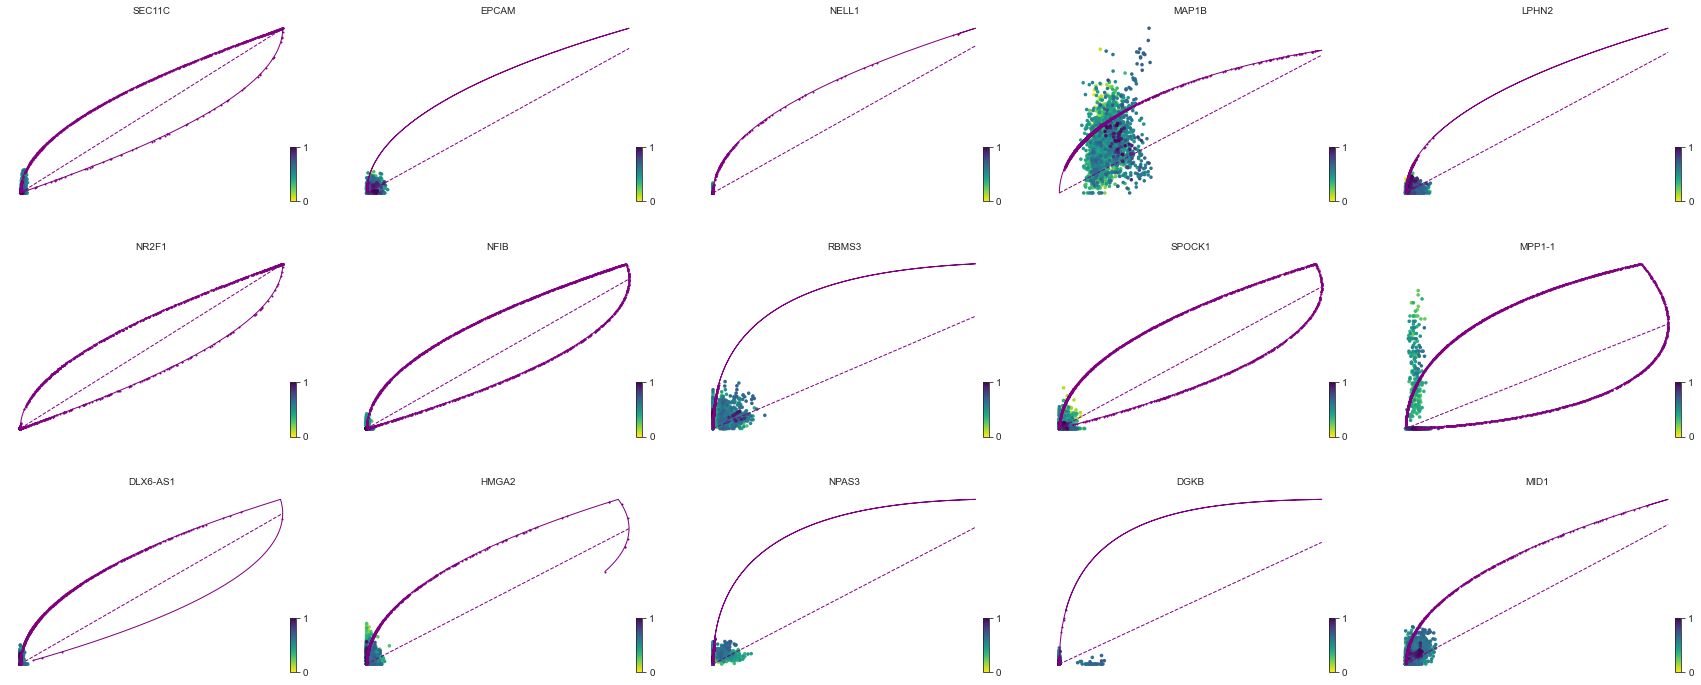

  0%|          | 0/866 [00:00<?, ?gene/s]

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/scvelo/tools/dynamical_model.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/scvelo/tools/dynamical_model.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


  0%|          | 0/1849 [00:00<?, ?cells/s]

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


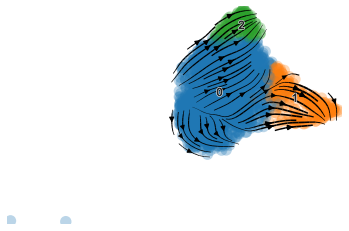

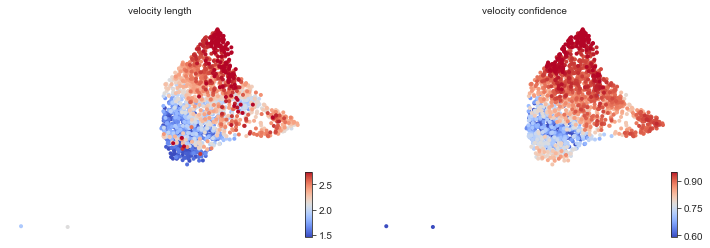

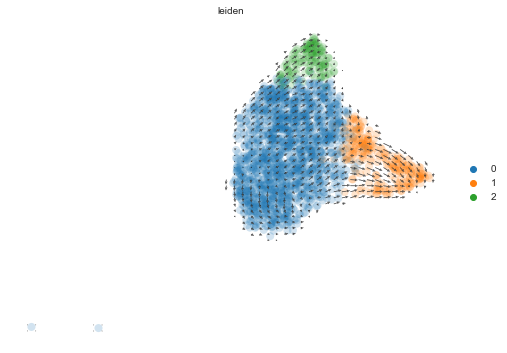

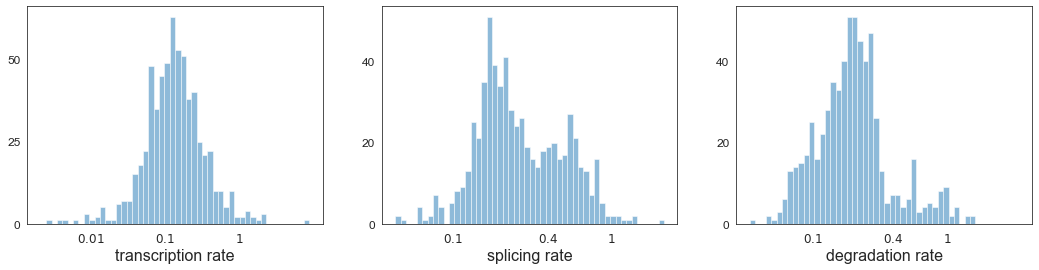

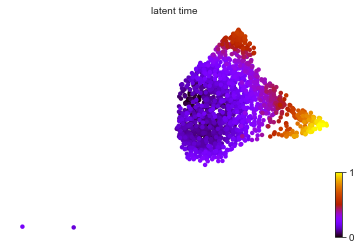

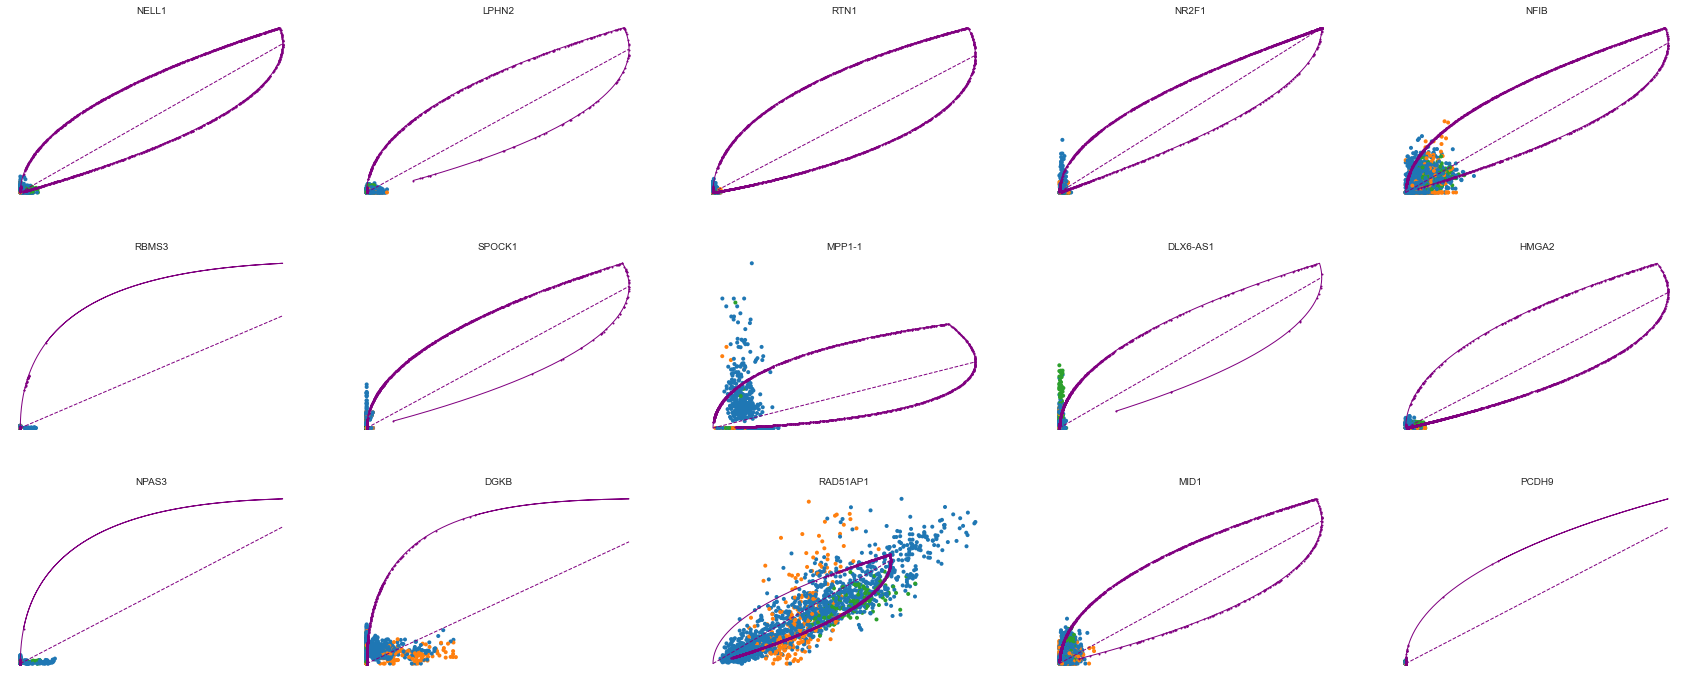

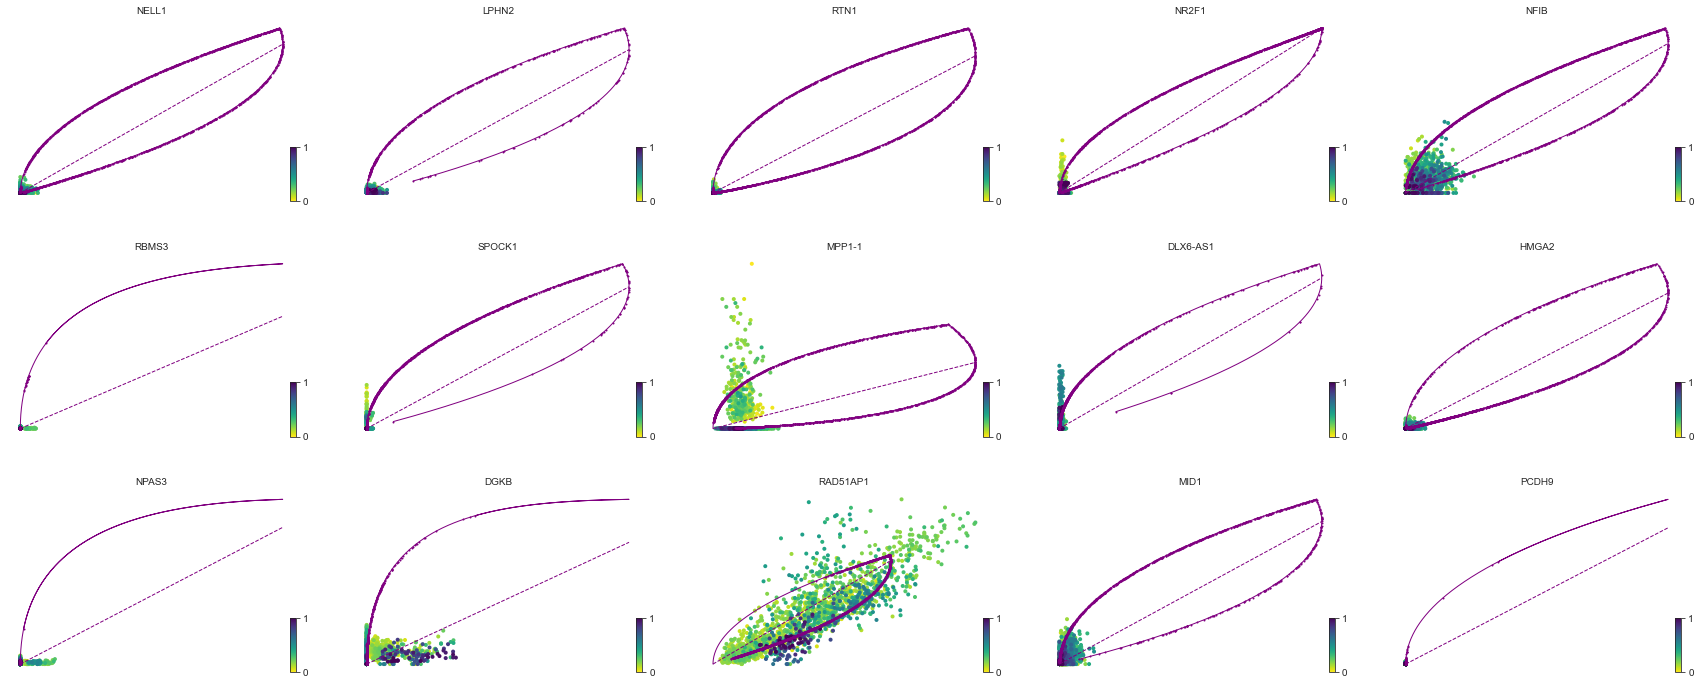

In [47]:
from scvelo import settings
settings.verbosity = 0
for i in list(adata.obs.cline.unique()):
    tmp = adata[adata.obs.cline == i].copy()
    rna_velocity_recipe(tmp, copy = False, basis = 'umap', resolution=.2, save=i)

So for the cell lines, it looks like there aren't many dynamics after all. This makes sense, since there really are not any perturbations that would cause dynamics. Furthermore, we would expect cells to move from A to other cell types if A are most proliferative but don't overtake populations (like in Lim et al.)